<a href="https://colab.research.google.com/github/OnyedikachiOnwuachuke/Stock-Price-Prediction-Using-Sentiment-Analysis/blob/main/PREDICTING_TESLA_STOCK_PRICE_USING_SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Importing necessary libraries
!pip install yfinance
import yfinance as yf
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For machine learning models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error

# For time series models
from statsmodels.tsa.arima.model import ARIMA

# For LSTM
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [3]:
# Loading the stock price data from yahoo finance with the company ticker

TSLA = yf.Ticker("TSLA")
# All the information about the the comapany ( Tesla Inc.)
TSLA.info

{'address1': '1 Tesla Road',
 'city': 'Austin',
 'state': 'TX',
 'zip': '78725',
 'country': 'United States',
 'phone': '512 516 8177',
 'website': 'https://www.tesla.com',
 'industry': 'Auto Manufacturers',
 'industryKey': 'auto-manufacturers',
 'industryDisp': 'Auto Manufacturers',
 'sector': 'Consumer Cyclical',
 'sectorKey': 'consumer-cyclical',
 'sectorDisp': 'Consumer Cyclical',
 'longBusinessSummary': 'Tesla, Inc. designs, develops, manufactures, leases, and sells electric vehicles, and energy generation and storage systems in the United States, China, and internationally. The company operates in two segments, Automotive, and Energy Generation and Storage. The Automotive segment offers electric vehicles, as well as sells automotive regulatory credits; and non-warranty after-sales vehicle, used vehicles, body shop and parts, supercharging, retail merchandise, and vehicle insurance services. This segment also provides sedans and sport utility vehicles through direct and used vehic

In [4]:
# To show, describe and give the necessary information about the stock data
stock_data = TSLA.history(period="max")
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500,0.0,0.0
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500,0.0,0.0
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000,0.0,0.0
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000,0.0,0.0
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500,0.0,0.0
...,...,...,...,...,...,...,...
2024-10-21 00:00:00-04:00,218.899994,220.479996,215.729996,218.850006,47329000,0.0,0.0
2024-10-22 00:00:00-04:00,217.309998,218.220001,215.259995,217.970001,43268700,0.0,0.0
2024-10-23 00:00:00-04:00,217.130005,218.720001,212.110001,213.649994,80938900,0.0,0.0


In [5]:
# Check the data structure and summary of the stock data
print("Data Info:")
print(stock_data.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3607 entries, 2010-06-29 00:00:00-04:00 to 2024-10-25 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3607 non-null   float64
 1   High          3607 non-null   float64
 2   Low           3607 non-null   float64
 3   Close         3607 non-null   float64
 4   Volume        3607 non-null   int64  
 5   Dividends     3607 non-null   float64
 6   Stock Splits  3607 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 225.4 KB
None


In [6]:
# Display basic statistical details of the stock data
print("\nStatistical Summary:")
print(stock_data.describe())



Statistical Summary:
              Open         High          Low        Close        Volume  \
count  3607.000000  3607.000000  3607.000000  3607.000000  3.607000e+03   
mean     78.082957    79.786949    76.270410    78.069970  9.668763e+07   
std     103.524082   105.811375   101.039414   103.461999  7.809811e+07   
min       1.076000     1.108667     0.998667     1.053333  1.777500e+06   
25%      11.876667    12.137000    11.573667    11.905000  4.840425e+07   
50%      17.640667    17.957333    17.379999    17.694000  8.198160e+07   
75%     173.560005   176.500000   169.169998   173.590004  1.224495e+08   
max     411.470001   414.496674   405.666656   409.970001  9.140820e+08   

       Dividends  Stock Splits  
count     3607.0   3607.000000  
mean         0.0      0.002218  
std          0.0      0.097076  
min          0.0      0.000000  
25%          0.0      0.000000  
50%          0.0      0.000000  
75%          0.0      0.000000  
max          0.0      5.000000  


In [7]:
# Check for missing values on the stock data
print("\nMissing Values:")
print(stock_data.isnull().sum())



Missing Values:
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64


In [11]:
# Display the shape of the stock data
print("\nShape of the Data:")
print(stock_data.shape)


Shape of the Data:
(3607, 7)


In [18]:
stock_data = stock_data.drop(columns=['Volume', 'Dividends', 'Stock Splits'])
stock_data

,Open,High,Low,Close
Date,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000
...,...,...,...,...
2024-10-21 00:00:00-04:00,218.899994,220.479996,215.729996,218.850006
2024-10-22 00:00:00-04:00,217.309998,218.220001,215.259995,217.970001
2024-10-23 00:00:00-04:00,217.130005,218.720001,212.110001,213.649994


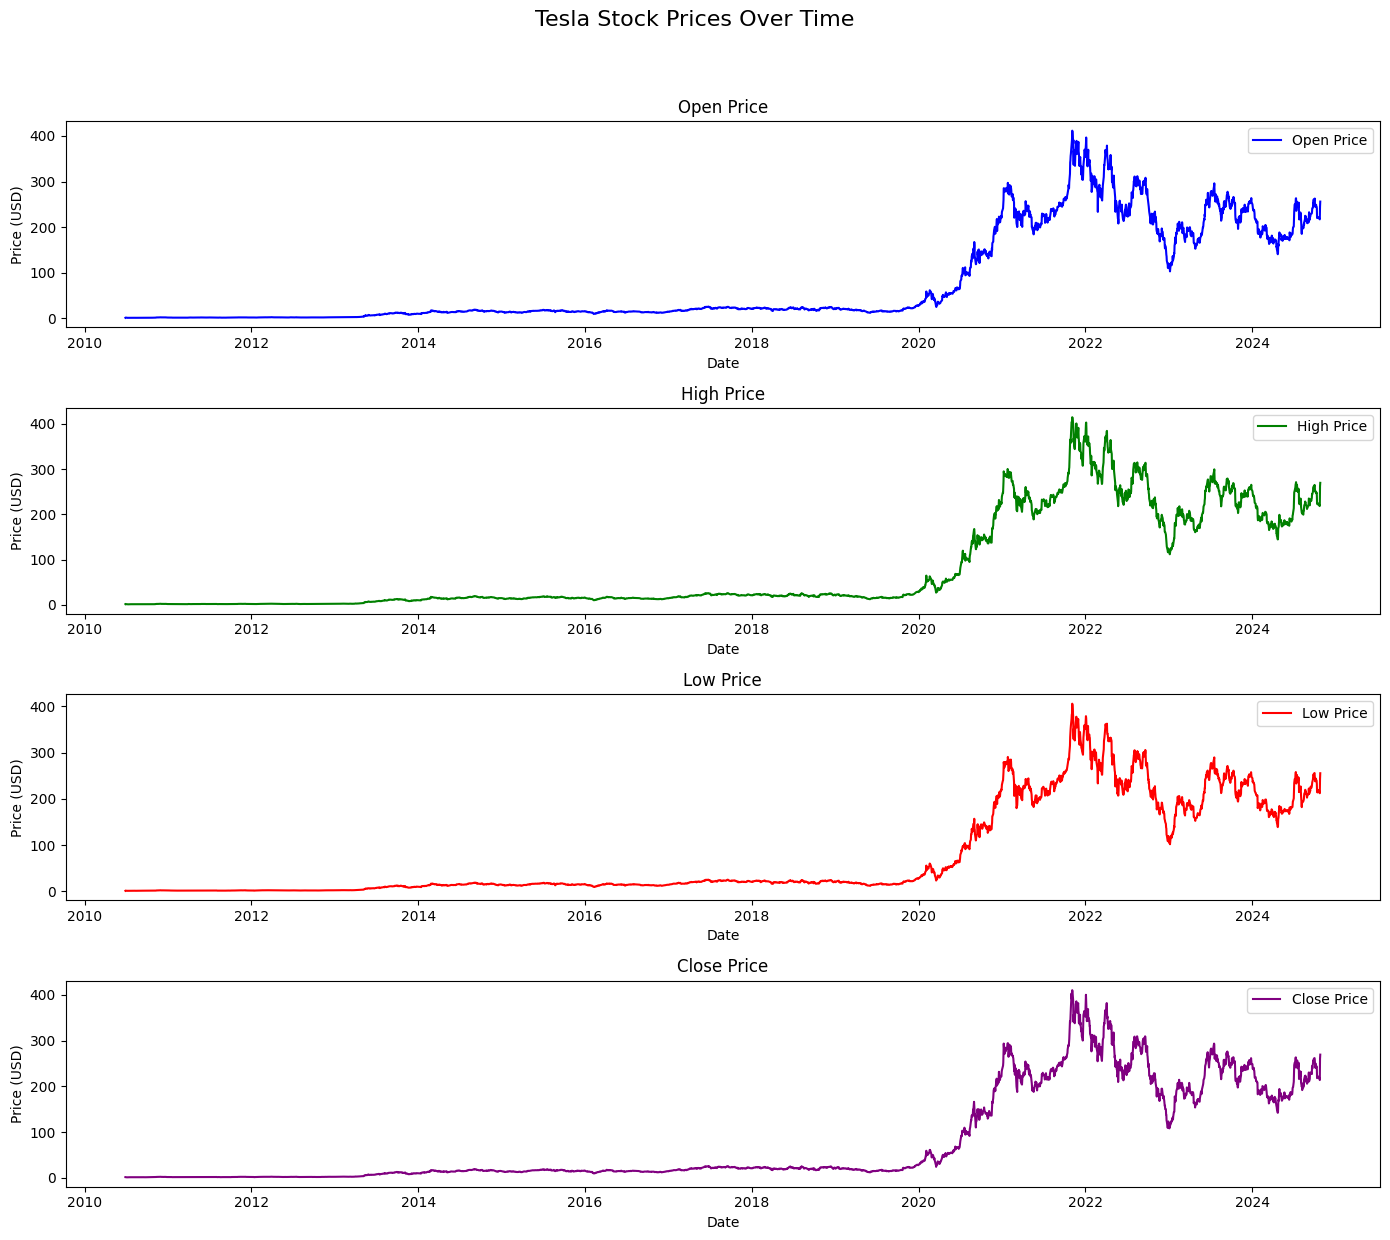

In [24]:
# Creating a 4x1 subplot for Open, High, Low, and Close prices without sharing the x-axis
fig, axs = plt.subplots(4, 1, figsize=(14, 13))
fig.suptitle('Tesla Stock Prices Over Time', fontsize=16)

# Plotting each price type in a separate subplot without shared x-axes
# 1. Open Price
axs[0].plot(stock_data.index, stock_data['Open'], label='Open Price', color='blue')
axs[0].set_title('Open Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Price (USD)')
axs[0].legend()

# 2. High Price
axs[1].plot(stock_data.index, stock_data['High'], label='High Price',color='green')
axs[1].set_title('High Price')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Price (USD)')
axs[1].legend()


# 3. Low Price
axs[2].plot(stock_data.index, stock_data['Low'], label='Low Price', color='red')
axs[2].set_title('Low Price')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Price (USD)')
axs[2].legend()

# 4. Close Price
axs[3].plot(stock_data.index, stock_data['Close'], label='Close Price',color='purple')
axs[3].set_title('Close Price')
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Price (USD)')
axs[3].legend()

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


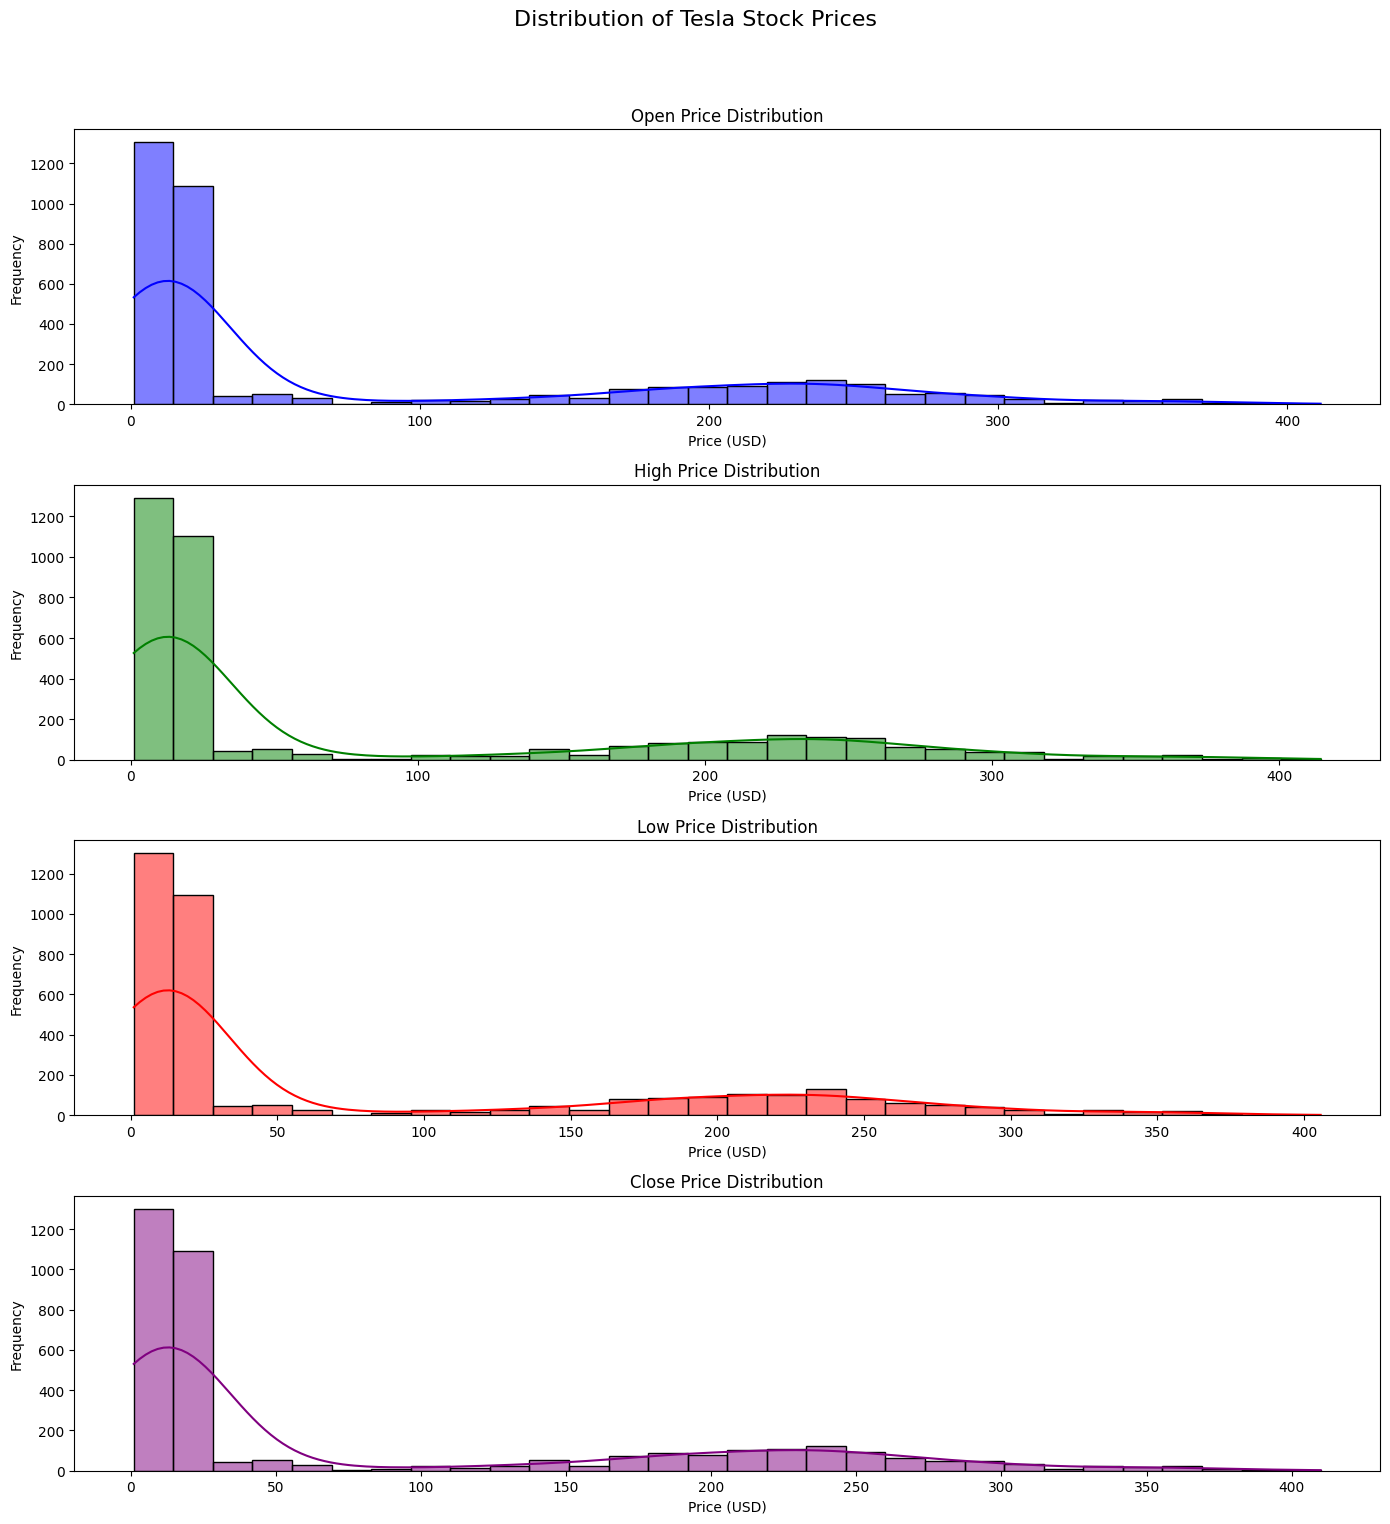

In [25]:
# Creating a 4x1 subplot for Open, High, Low, and Close price distributions
fig, axs = plt.subplots(4, 1, figsize=(14, 16))
fig.suptitle('Distribution of Tesla Stock Prices', fontsize=16)

# Plotting each price type as a histogram
# 1. Open Price Distribution
sns.histplot(stock_data['Open'], bins=30, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Open Price Distribution')
axs[0].set_xlabel('Price (USD)')
axs[0].set_ylabel('Frequency')

# 2. High Price Distribution
sns.histplot(stock_data['High'], bins=30, kde=True, color='green', ax=axs[1])
axs[1].set_title('High Price Distribution')
axs[1].set_xlabel('Price (USD)')
axs[1].set_ylabel('Frequency')

# 3. Low Price Distribution
sns.histplot(stock_data['Low'], bins=30, kde=True, color='red', ax=axs[2])
axs[2].set_title('Low Price Distribution')
axs[2].set_xlabel('Price (USD)')
axs[2].set_ylabel('Frequency')

# 4. Close Price Distribution
sns.histplot(stock_data['Close'], bins=30, kde=True, color='purple', ax=axs[3])
axs[3].set_title('Close Price Distribution')
axs[3].set_xlabel('Price (USD)')
axs[3].set_ylabel('Frequency')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


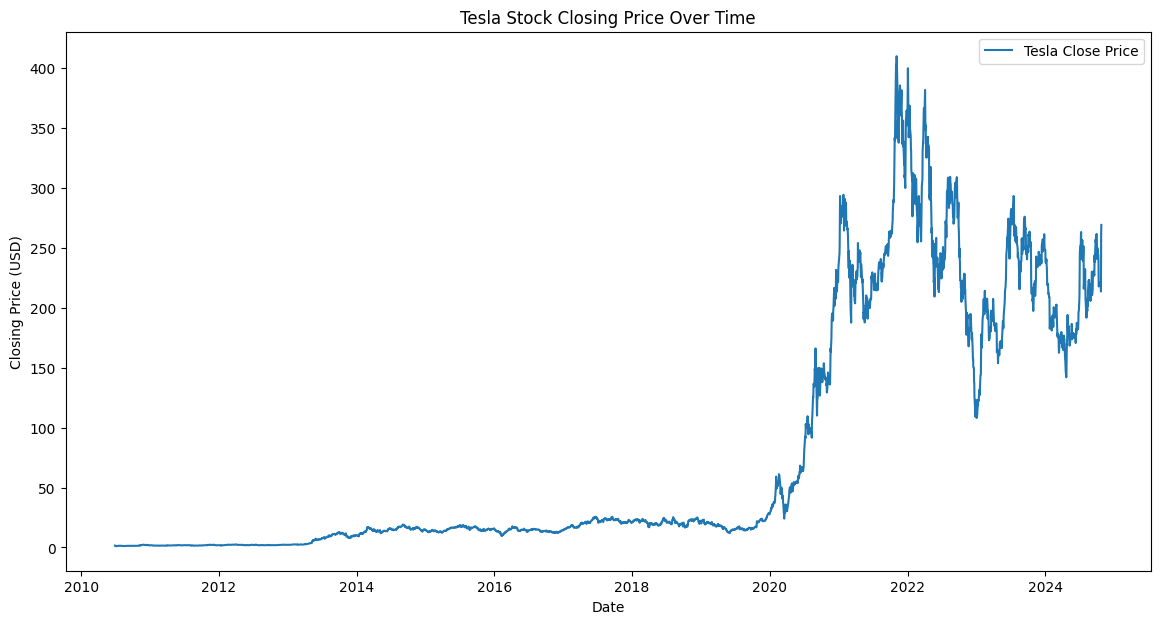

In [19]:
# Plotting the Closing Price over time
plt.figure(figsize=(14, 7))
plt.plot(stock_data.index, stock_data['Close'], label='Tesla Close Price')
plt.title('Tesla Stock Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.show()

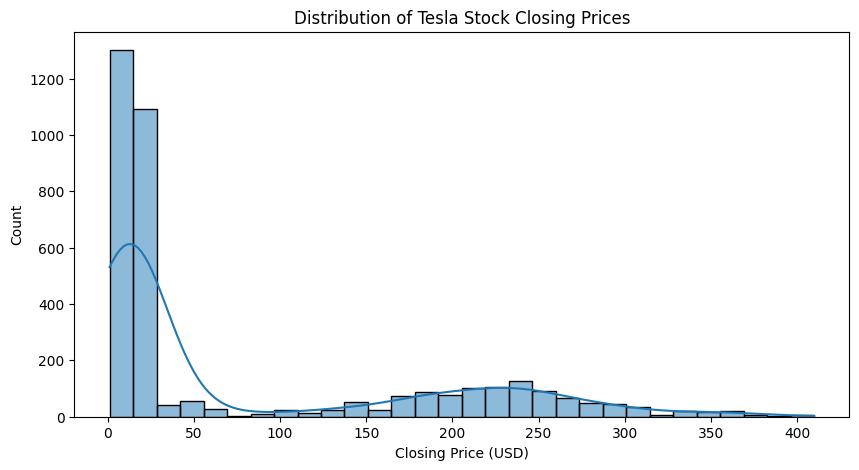

In [16]:
# Distribution of Closing Prices
plt.figure(figsize=(10, 5))
sns.histplot(stock_data['Close'], kde=True, bins=30)
plt.title('Distribution of Tesla Stock Closing Prices')
plt.xlabel('Closing Price (USD)')
plt.show()

                  Open      High       Low     Close    Volume  Dividends  \
Open          1.000000  0.999722  0.999626  0.999215  0.097751        NaN   
High          0.999722  1.000000  0.999631  0.999647  0.101449        NaN   
Low           0.999626  0.999631  1.000000  0.999687  0.094495        NaN   
Close         0.999215  0.999647  0.999687  1.000000  0.098750        NaN   
Volume        0.097751  0.101449  0.094495  0.098750  1.000000        NaN   
Dividends          NaN       NaN       NaN       NaN       NaN        NaN   
Stock Splits  0.028263  0.029834  0.028244  0.030237  0.042506        NaN   

              Stock Splits  
Open              0.028263  
High              0.029834  
Low               0.028244  
Close             0.030237  
Volume            0.042506  
Dividends              NaN  
Stock Splits      1.000000  


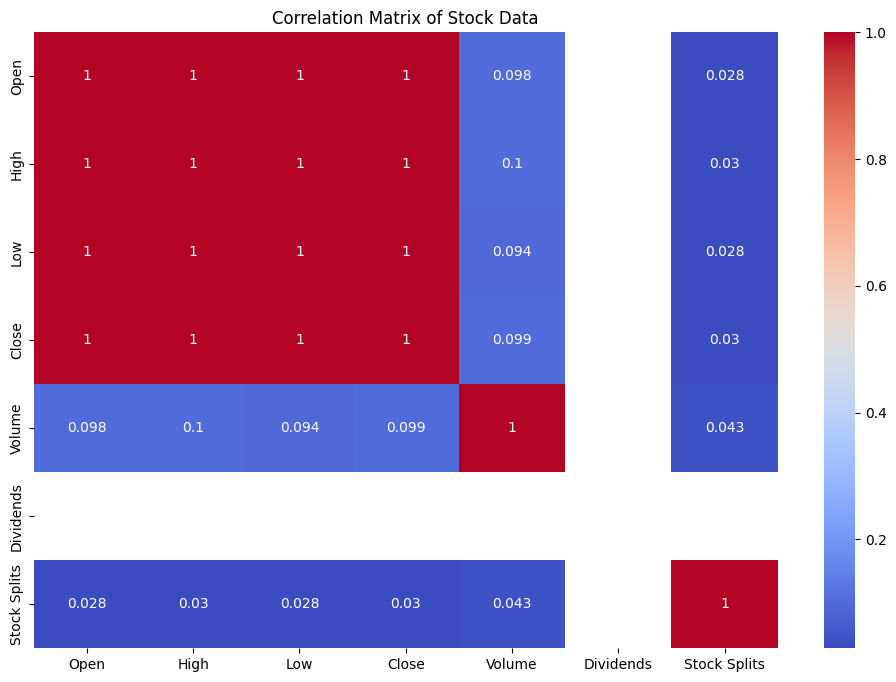

<Figure size 1200x600 with 0 Axes>

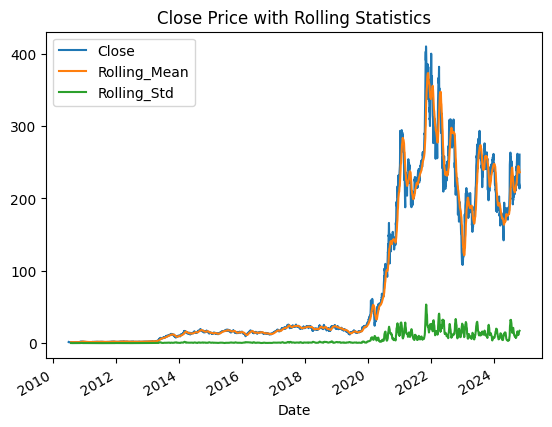

Open             0
High             0
Low              0
Close            0
Volume           0
Dividends        0
Stock Splits     0
Rolling_Mean    19
Rolling_Std     19
dtype: int64
count    3.606000e+03
mean     9.666982e+07
std      7.810149e+07
min      1.777500e+06
25%      4.839338e+07
50%      8.198130e+07
75%      1.224334e+08
max      9.140820e+08
Name: Volume, dtype: float64


<ipython-input-9-174a4d2e098e>:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


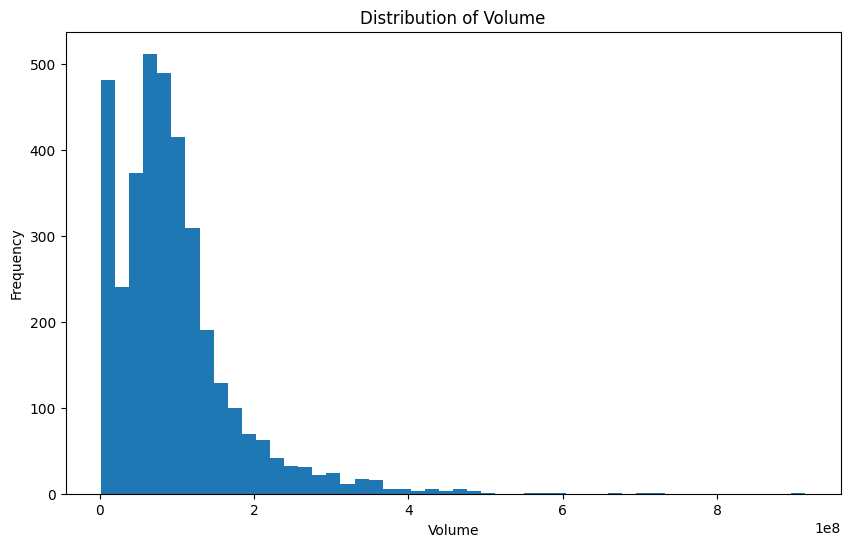

In [9]:
# prompt: what other information can we get from the stock_data

# Analyze correlations between features
correlation_matrix = stock_data.corr()
print(correlation_matrix)

# Visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Stock Data')
plt.show()

# Calculate rolling statistics (e.g., moving averages)
window_size = 20  # Example window size
stock_data['Rolling_Mean'] = stock_data['Close'].rolling(window=window_size).mean()
stock_data['Rolling_Std'] = stock_data['Close'].rolling(window=window_size).std()

# Plot rolling statistics
plt.figure(figsize=(12, 6))
stock_data[['Close', 'Rolling_Mean', 'Rolling_Std']].plot()
plt.title('Close Price with Rolling Statistics')
plt.show()




# Explore individual columns in more detail
print(stock_data['Volume'].describe())  # Example for volume
plt.figure(figsize=(10, 6))
plt.hist(stock_data['Volume'], bins=50)
plt.title('Distribution of Volume')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()

# You can perform similar analysis for other columns like 'Open', 'High', 'Low', etc.